<font size=6><b>Bike Sharing Demand - ML

<img src="./logo.png">
* ref : https://www.kaggle.com/competitions/bike-sharing-demand/data <br>
* ref : https://dacon.io/competitions/official/235985/data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


sns.set()

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
# from IPython.core.display import display, HTML
from IPython.display import display, HTML

display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

import warnings
warnings.filterwarnings(action='ignore')

In [2]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from sklearn.ensemble     import RandomForestRegressor
from sklearn.tree         import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
# ---- 추가 모델
from sklearn.ensemble     import AdaBoostRegressor, VotingRegressor
from xgboost              import XGBRegressor
from lightgbm             import LGBMRegressor



# Data Load

In [3]:
train = pd.read_csv("./train.csv", parse_dates=['datetime'])
test  = pd.read_csv("./test.csv" , parse_dates=['datetime'])

In [4]:
df_list = [train, test]
for df in df_list:
    df.rename(columns = {'datetime' : 'regdate', 'count' : 'regcount'}, inplace = True)
    df.columns = df.columns.str.lower()
    print(df.info())    
    print("====="*10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   regdate     10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  regcount    10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dty

# Feature Engineering

## 파생피쳐
* regdate
* day_type

In [5]:
df_list = [train, test]
for df in df_list:
    df['y'] = df['regdate'].dt.year
    df['m'] = df['regdate'].dt.month
    df['d'] = df['regdate'].dt.day
    df['h'] = df['regdate'].dt.hour
    df['w'] = df['regdate'].dt.dayofweek
    #df['woy'] = df['regdate'].dt.weekofyear
    
    
    df['day_type'] = 0
    df['day_type'] = np.where( (df['holiday']==0) & (df['workingday'] == 1),   1,  df['day_type'])
    df['day_type'] = np.where( (df['holiday']==1) & (df['workingday'] == 0),   2,  df['day_type'])
    
    # df['peak']   = df[['h', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['h'] == 8 or 17 <= x['h'] <= 18 or 12 <= x['h'] <= 12)) or (x['workingday'] == 0 and  10 <= x['h'] <= 19)], axis = 1)
    # df['ideal']  = df[['temp', 'windspeed']].apply(lambda x: (0, 1)[x['temp'] > 27 and x['windspeed'] < 30], axis = 1)
    # df['sticky'] = df[['humidity', 'workingday']].apply(lambda x: (0, 1)[x['workingday'] == 1 and x['humidity'] >= 60], axis = 1)
    
    #sandy
    df['holiday'] = df[['m', 'd', 'holiday', 'y']].apply(lambda x: (x['holiday'], 1)[x['y'] == 2012 and x['m'] == 10 and (x['m'] in [30])], axis = 1)
    #christmas day and others
    df['holiday'] = df[['m', 'd', 'holiday']].apply(lambda x: (x['holiday'], 1)[x['m'] == 12 and (x['m'] in [24, 26, 31])], axis = 1)
    df['workingday'] = df[['m', 'd', 'workingday']].apply(lambda x: (x['workingday'], 0)[x['m'] == 12 and x['m'] in [24, 31]], axis = 1)
    
    df.set_index('regdate', inplace=True)
    df = df.drop('d', axis=1, inplace=True)
    
    # oh - encoding
    
    
    # target scaler
    
    # 

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6493 entries, 2011-01-20 00:00:00 to 2012-12-31 23:00:00
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      6493 non-null   int64  
 1   holiday     6493 non-null   int64  
 2   workingday  6493 non-null   int64  
 3   weather     6493 non-null   int64  
 4   temp        6493 non-null   float64
 5   atemp       6493 non-null   float64
 6   humidity    6493 non-null   int64  
 7   windspeed   6493 non-null   float64
 8   y           6493 non-null   int64  
 9   m           6493 non-null   int64  
 10  h           6493 non-null   int64  
 11  w           6493 non-null   int64  
 12  day_type    6493 non-null   int64  
dtypes: float64(3), int64(10)
memory usage: 710.2 KB


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  regcount    10886 non-null  int64  
 11  y           10886 non-null  int64  
 12  m           10886 non-null  int64  
 13  h           10886 non-null  int64  
 14  w           10886 non-null  int64  
 15  day_type    10886 non-null  int64  
dtypes: float64(3), int64(13)
memory usage: 1.4 MB


In [8]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,regcount,y,m,h,w,day_type
regdate,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,5,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,0
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,5,0
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,3,5,0
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,4,5,0


In [9]:
# my_fit_score(train)

## windspeed 0 채우기

In [10]:
train.shape, test.shape

((10886, 16), (6493, 13))

In [11]:
def my_fill_windspeed(df):
    target = df[['regcount','casual','registered']]
    df = df.drop(['regcount','casual','registered'], axis=1)

    df1   = df[df['windspeed'] != 0]
    y_df1 = df1['windspeed']
    X_df1 = df1.drop('windspeed', axis=1)
    
    rf = RandomForestRegressor(random_state=11)
    X_df1_8, X_df1_2, y_df1_8, y_df1_2 = train_test_split(X_df1, y_df1, test_size=0.2, random_state=11)
    rf.fit(X_df1_8, y_df1_8)
    
    pred = rf.predict(X_df1_2)
    mse_score = mean_squared_error(y_df1_2, pred)
    print("RMSE : ", np.sqrt(mse_score) )

    df0 = df[df['windspeed'] == 0]
    y_df0 = df0['windspeed']
    X_df0 = df0.drop('windspeed', axis=1)
    pred = rf.predict(X_df0)
    widx = X_df0.index.values
    df.loc[widx, 'windspeed'] = pred
    return pd.concat([df, target], axis=1)

In [12]:
df = pd.concat([train, test], axis=0, ignore_index=True)
train_idx = df.iloc[:train.shape[0], :].index
test_idx  = df.iloc[train.shape[0]:, :].index
#---------------------------------
df = my_fill_windspeed(df)
#---------------------------------
train = df.loc[train_idx]
test  = df.loc[test_idx]
test = test.reset_index(drop=True)

RMSE :  4.8540409129695705


## 원핫인코딩

In [13]:
for col in train.columns:
    print(col, df[col].nunique())

season 4
holiday 2
workingday 2
weather 4
temp 50
atemp 65
humidity 89
windspeed 2185
y 2
m 12
h 24
w 7
day_type 3
regcount 822
casual 309
registered 731


In [14]:
print(df.shape)
df = pd.get_dummies(df, columns=['season', 'weather','m', 'y', 'h', 'w', 'day_type'])
df.info()

(17379, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 65 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     17379 non-null  int64  
 1   workingday  17379 non-null  int64  
 2   temp        17379 non-null  float64
 3   atemp       17379 non-null  float64
 4   humidity    17379 non-null  int64  
 5   windspeed   17379 non-null  float64
 6   regcount    10886 non-null  float64
 7   casual      10886 non-null  float64
 8   registered  10886 non-null  float64
 9   season_1    17379 non-null  uint8  
 10  season_2    17379 non-null  uint8  
 11  season_3    17379 non-null  uint8  
 12  season_4    17379 non-null  uint8  
 13  weather_1   17379 non-null  uint8  
 14  weather_2   17379 non-null  uint8  
 15  weather_3   17379 non-null  uint8  
 16  weather_4   17379 non-null  uint8  
 17  m_1         17379 non-null  uint8  
 18  m_2         17379 non-null  uint8  
 19  m_3         1

In [15]:
df.columns

Index(['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
       'regcount', 'casual', 'registered', 'season_1', 'season_2', 'season_3',
       'season_4', 'weather_1', 'weather_2', 'weather_3', 'weather_4', 'm_1',
       'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11',
       'm_12', 'y_2011', 'y_2012', 'h_0', 'h_1', 'h_2', 'h_3', 'h_4', 'h_5',
       'h_6', 'h_7', 'h_8', 'h_9', 'h_10', 'h_11', 'h_12', 'h_13', 'h_14',
       'h_15', 'h_16', 'h_17', 'h_18', 'h_19', 'h_20', 'h_21', 'h_22', 'h_23',
       'w_0', 'w_1', 'w_2', 'w_3', 'w_4', 'w_5', 'w_6', 'day_type_0',
       'day_type_1', 'day_type_2'],
      dtype='object')

* 22

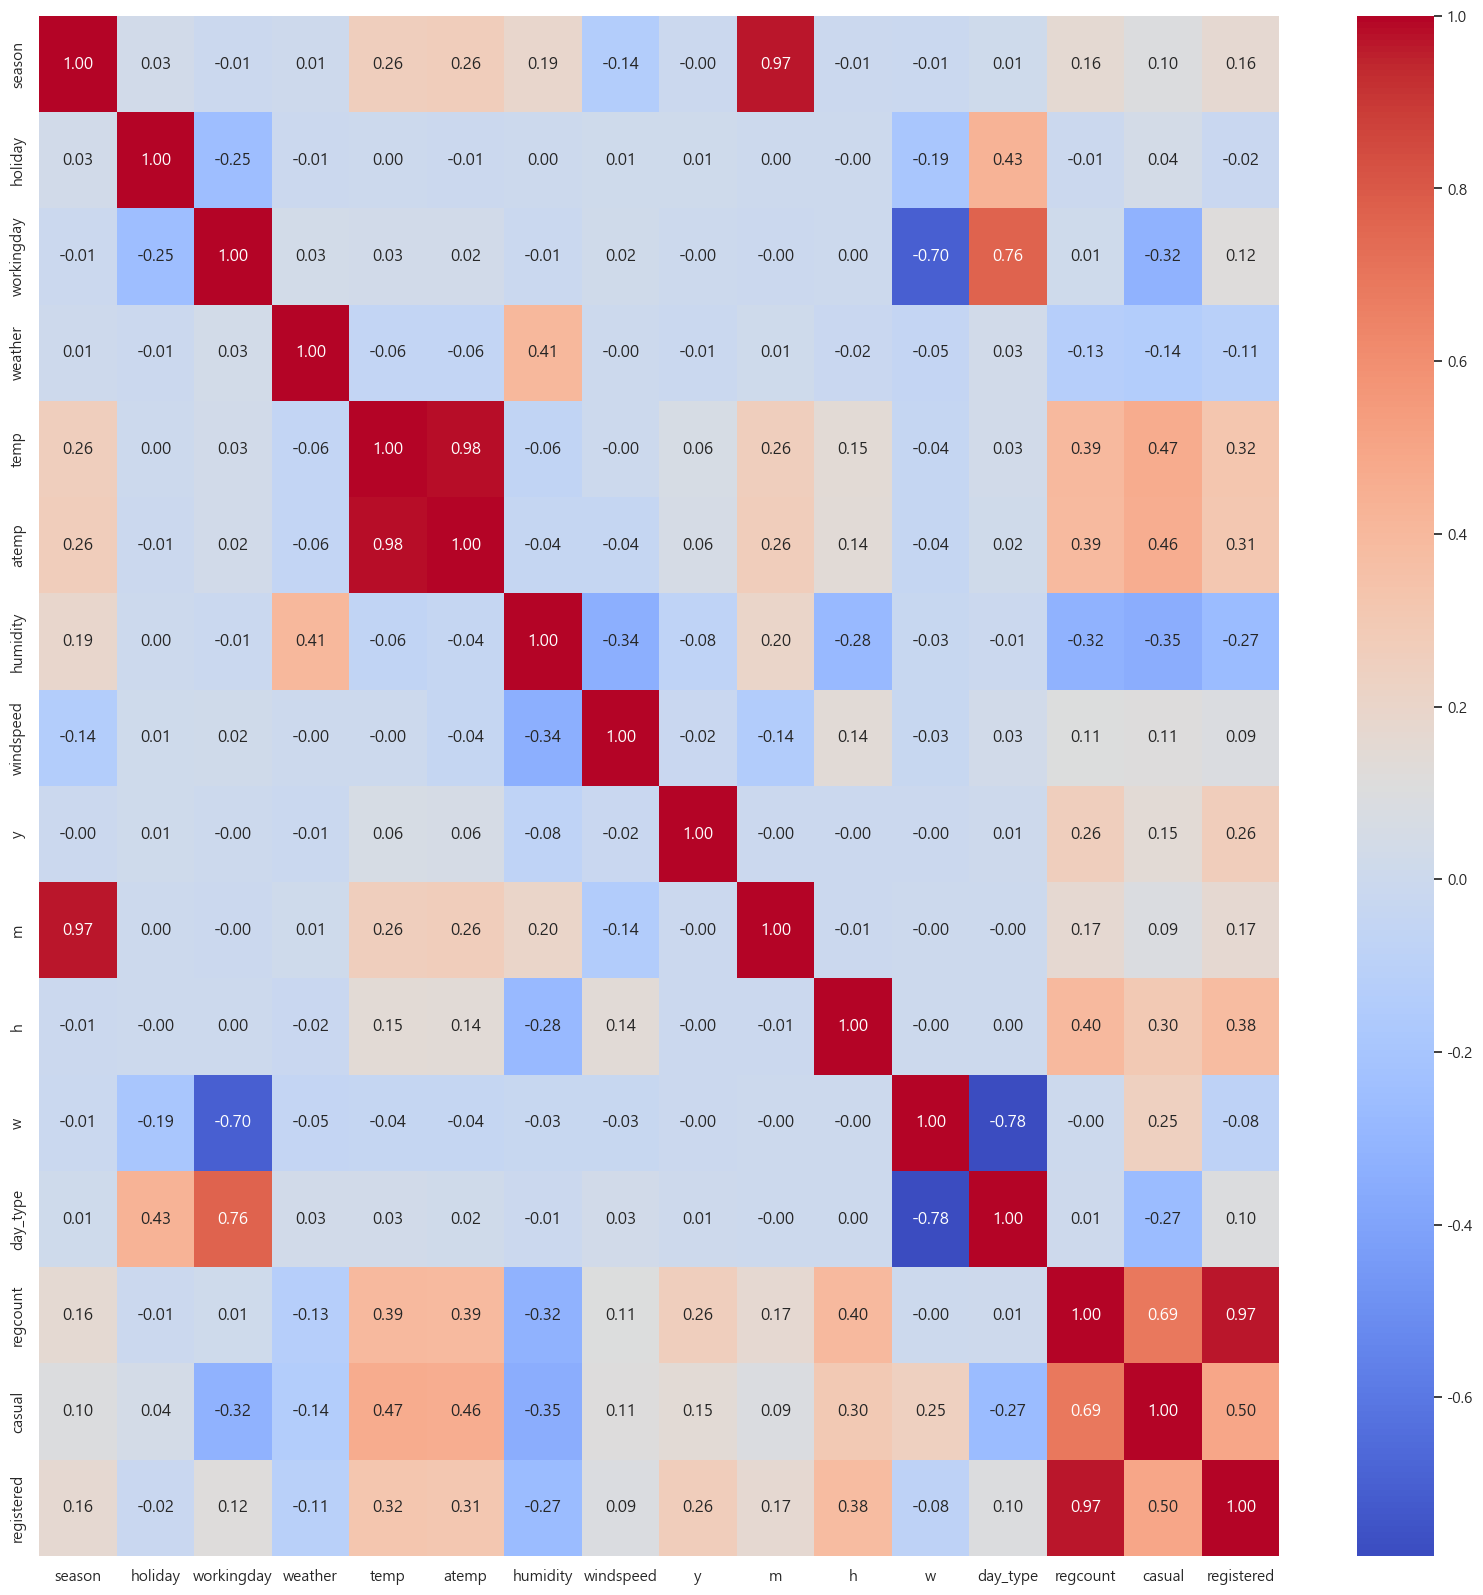

In [16]:
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


In [17]:
# plt.figure(figsize=(20,20))
# sns.heatmap(df[['casual', 'registered', 
#        'h_0', 'h_1','h_2', 'h_3', 'h_4', 'h_5', 'h_6', 'h_7', 'h_8', 'h_9', 'h_10', 'h_11',
#        'h_12', 'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18', 'h_19', 'h_20',
#        'h_21', 'h_22', 'h_23',
#        #          ,'m_1','m_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11',
#        # 'm_12', 'y_2011', 'y_2012',  'w_0', 'w_1', 'w_2', 'w_3', 'w_4', 'w_5', 'w_6',
#        # ,'holiday', 'workingday',    
#        # 'day_type_0', 'day_type_1', 'day_type_2'
#         ]].corr(), annot=True, fmt=".2f", cmap="coolwarm")
# plt.show()


# 학습

## 타켓 선정
* 답안지 : count 제출
* regcount(A패턴)  = registered(A2패턴) + casual (B패턴) 
* <font color=red><b>registered(A2패턴) + casual (B패턴)  --> 이 값을 답안으로 제출

## 최종피쳐 선정

In [18]:
train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'y', 'm', 'h', 'w', 'day_type', 'regcount',
       'casual', 'registered'],
      dtype='object')

<pre>
타겟(1) : 'casual' + 'registered'
타겟(2) : 'regcount'


'd' 피쳐 삭제
('m', 'h'),  'y', 'd' -->'w'


(+)3개 : 'holiday', 'workingday', 'day_type'
(+)2개 : 'holiday', 'workingday'
(+)1개 : 'day_type'


'weather', 'humidity',  'season', 
(+)'windspeed' : 'h' 비례? / 'm' 반비례?


다중공선 : (상관계수가 높은 경우)
'regcount' 'registered' 'casual' : 0.97  --> 'regcount' vs. 'registered'+'casual'
'temp' 'atemp'                   : 0.98  --> 'atemp' drop

선택적으로 모델에 적용
(+)'w' 'day_type' : -0.78
(+)'season' 'm'   : 0.97


* ('m', 'h'),  'y', 'w', 'weather', 'humidity',  'season', 'temp'
* (+)'windspeed'
* (+)('holiday', 'workingday'), ('day_type')
* (+)('w' 'day_type') : -0.78
* (+)('m') 'season'    : 0.97


## 학습 & 평가
* ref : https://suboptimal.wiki/explanation/mse/

*  $ RMSLE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{log(Y_i+1) - log(\hat{Y_i}+1)}{N}\Big)^2}}$

## 공통함수

In [19]:
# ! pip install xgboost
# ! pip install lightgbm 

* class sklearn.linear_model.Ridge(alpha=1.0, *, fit_intercept=True, copy_X=True, max_iter=None, tol=0.0001, solver='auto', positive=False, random_state=None)
* class sklearn.linear_model.Lasso(alpha=1.0, *, fit_intercept=True, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')

* https://towardsdatascience.com/custom-implementation-of-feature-importance-for-your-voting-classifier-model-859b573ce0e0
* [bagging vs boosting] : http://egloos.zum.com/incredible/v/7478090
* [eval plot] https://hyemin-kim.github.io/2020/08/04/S-Python-sklearn4/#2-%ED%8F%89%EA%B0%80-%EC%A7%80%ED%91%9C-%EB%A7%8C%EB%93%A4%EA%B8%B0

In [20]:
modelsss = Ridge(alpha=1.0, random_state=0)
modelsss.__class__.__name__

'Ridge'

In [21]:
def my_fit_score(df, chart_view = False) :
    model_list = [ 
                   ("RIDGE"  , Ridge(alpha=1.0, random_state=0)),
                   ("LASSO"  , Lasso(alpha=1.0, random_state=0)),
                   ("DTR"    , DecisionTreeRegressor(random_state=0)),
                   ("RF"     , RandomForestRegressor(random_state=0)),
                   ("LR"     , LinearRegression()                   ),
                   ("ABOOST" , AdaBoostRegressor(random_state=0)                  ),
                   ("XGB"    , XGBRegressor(random_state=0)                       ),   #booster=gblinear
                   ("LGBM"   , LGBMRegressor(random_state=0)                      ),
                   # model.booster().get_score(importance_type='weight')
                   ("VR-XGB-LGBM"  , VotingRegressor([("XGB", XGBRegressor(random_state=0)), ("LGBM", LGBMRegressor(random_state=0))]) ) ,
                   ("VR-RF-LGBM"   , VotingRegressor([("DTR", RandomForestRegressor(random_state=0)), ("LGBM", LGBMRegressor(random_state=0))]) )
                 ]
    
    
    
    #아웃라이어는 스케일 전에 지우기(정규화 더 정교하게 하기 위해)
    del_idx_list = []
    idx = df[df['weather']==4].index
    del_idx_list.extend(idx)
    idx = df[df['temp']>40].index
    del_idx_list.extend(idx)
    idx = df[df['windspeed']>50].index
    del_idx_list.extend(idx)
    df.drop(del_idx_list, axis=0, inplace=True)

    
    
    
    
    
    #---------(타켓피쳐:로그스케일링) -----------
    # y_c = df['casual'] 
    # y_r = df['registered'] 
    y_c = np.log1p( df['casual'] )
    y_r = np.log1p( df['registered'] )
    # print(y_c[:5], y_r[:5])
    
    X = df.drop(['regcount','casual','registered'], axis=1)
    
    #------------------------------------------------
    # 연속형 피쳐 스케일링
    # 'temp', 'atemp','humidity', 'windspeed'
    #------------------------------------------------
    X['temp']      = np.log1p( X['temp'] )
    X['atemp']     = np.log1p( X['atemp'] )
    X['humidity']  = np.log1p( X['humidity'] )
    X['windspeed'] = np.log1p( X['windspeed'] )
    
    #------------------------------------------------
    # 다중공선
    # 'temp', 'atemp'
    # 'season', 'm'
    # 'w', 'day_type'
    #------------------------------------------------
    X = X.drop(['atemp'], axis=1)
    #X = X.drop(['m'], axis=1)
    #X = X.drop(['w'], axis=1)
    
    #------------------------------------------------
    # 이산형 피쳐 원핫인코딩
    # ['season', 'weather','m', 'y', 'h', 'w', 'day_type']
    # X = pd.get_dummies(X, columns=['season', 'weather','m', 'y', 'h', 'w', 'day_type'])
    
    
    for tpl in model_list :
        print( tpl[0] ) 
        
        
        model = tpl[1]
        X_train, X_test, y_train, y_r_test = train_test_split(X, y_r, random_state=0, test_size=0.2)
        model.fit(X_train, y_train)
        
        if bool(chart_view): #차트뷰 옵션 걸기(true일 때만 실행)
            my_view_chart(tpl[0], model, X_train)
        
        y_r_pred = model.predict(X_test)
        
       
        model = tpl[1]
        X_train, X_test, y_train, y_c_test = train_test_split(X, y_c, random_state=0, test_size=0.2)
        model.fit(X_train, y_train)
        y_c_pred = model.predict(X_test)
        
        #---------(타켓피쳐:로그스케일링) 복원-----------
        y_pred_comb = np.expm1(y_r_pred)+np.expm1(y_c_pred)
        y_real_comb = np.expm1(y_r_test)+np.expm1(y_c_test)
        y_pred_comb[y_pred_comb < 0] = 0
        
        # print("yrtest", y_r_test[:5])
        # print("yctest", y_c_test[:5])
        # print("ypred", y_pred_comb[:5])
        msle_score = mean_squared_log_error(y_real_comb, y_pred_comb)

        print("RMSLE: ", np.sqrt(msle_score)) 
        print("-"*30)
        

In [22]:
def my_view_chart(model_name, model, X_train):
    if tpl[0] == "RIDGE" :
            ax1 = plt.subplot(4,1,1)
            s = pd.Series(model.coef_, index=X_train.columns).sort_values()
            sns.barplot(x=s.values, y=s.index, ax=ax1)
            plt.show()
    elif tpl[0] == "RF" :
            ax2 = plt.subplot(4,1,2)
            s = pd.Series(model.feature_importances_, index=X_train.columns).sort_values()
            sns.barplot(x=s.values, y=s.index, ax=ax2)
            plt.show()
    elif tpl[0] == "XGB" :
            ax3 = plt.subplot(4,1,3)
            # Weight, Gain, Cover
            s = pd.Series(model.get_booster().get_score(importance_type='weight'), index=X_train.columns).sort_values()
            sns.barplot(x=s.values, y=s.index, ax=ax3)
            plt.show()
    elif tpl[0] == "LGBM" :
            ax4 = plt.subplot(4,1,4)  
            # Gain, Split
            #s = pd.Series(model.booster_.faeture_importance(importance_type="gain"), index=X_train.columns).sort_values()
            s = pd.Series(model.feature_importances_, index=X_train.columns).sort_values()
            sns.barplot(x=s.values, y=s.index, ax=ax4)
            plt.show()
    

## 점수보기
* RF  
RMSLE:  0.3288546947603633  : 원본  
RMSLE:  0.327712532218228   : 풍속채우기  
RMSLE:  0.3029460779805034  : 스케일링  

* VR-XGB-LGBM  
RMSLE:  0.2839304212238602  : 타겟스케일링  
RMSLE:  0.28362762650351697 : 연속형스케일링

In [23]:
my_fit_score(train)

RIDGE
RMSLE:  1.0122770577339413
------------------------------
LASSO
RMSLE:  1.1586806301168795
------------------------------
DTR
RMSLE:  0.40739009330829207
------------------------------
RF
RMSLE:  0.3093877272216494
------------------------------
LR
RMSLE:  1.0120349926458299
------------------------------
ABOOST
RMSLE:  0.6389488348540561
------------------------------
XGB
RMSLE:  0.2962814149590453
------------------------------
LGBM
RMSLE:  0.29343483294867656
------------------------------
VR-XGB-LGBM
RMSLE:  0.2878458556474499
------------------------------
VR-RF-LGBM
RMSLE:  0.29345506703116925
------------------------------


In [24]:
ddfdfdfdff

NameError: name 'ddfdfdfdff' is not defined

## Outlier 처리
* <font color=red size=4><b>train에만 처리

<pre>
RIDGE
RMSLE:  1.2381857382907928
------------------------------
LASSO
RMSLE:  1.225011162068078
------------------------------
DTR
RMSLE:  0.40846452875216704
------------------------------
RF
RMSLE:  0.33285798378220866
------------------------------
LR
RMSLE:  1.2382780216954419
------------------------------
ABOOST
RMSLE:  1.115326753305681
------------------------------
XGB
RMSLE:  0.4611753550135809
------------------------------
LGBM
RMSLE:  0.3999441627321239
------------------------------
VR-XGB-LGBM
RMSLE:  0.3877526497892151
------------------------------
VR-RF-LGBM
RMSLE:  0.34299001906970344
------------------------------

In [ ]:
train.shape, test.shape

* 아웃라이어는 스케일 전에 df에서 처리해서, 정규화를 더 디테일하게 만든다.

In [ ]:
train.shape, test.shape

## 점수보기

In [ ]:
# my_fit_score(train)